# Heteroscedastiacity and Autocorrelation-Corrected Tests (HAC)

**Have**: Datasets $x$ and $y$, may be different sizes

**Want**: Hypothesis Test $H_0: \mu(x) = \mu(y)$

**Canonical solutions**: t-test, MannWhitneyU

**Problem**: If datasets are autocorrelated, they fail i.i.d assumptions and cannot be tested

**Solution**:
1. Use a HAC-estimator to find autocorrelation-aware variance of each dataset
2. Use the variances in `t-test`

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind_from_stats

In [100]:
def autocorr(x, rho):
    rez = np.copy(x)
    for i in range(1, len(x)):
        rez[i] = rez[i-1]*rho + rez[i]*(1-rho)
    return rez

x = np.random.normal(0, 2, 1000)
x = autocorr(x, 0.5)
y = np.random.normal(1, 3, 1000)
y = autocorr(y, 0.5)

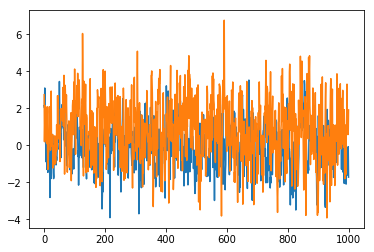

In [101]:
plt.figure()
plt.plot(x)
plt.plot(y)
plt.show()

In [148]:
def get_mean_std(x, hacLags=None):
    df = pd.DataFrame({'x' : x})
    model = smf.ols(formula='x ~ 1', data=df)
    if hacLags is None:
        results = model.fit()
    else:
        results = model.fit(cov_type='HAC',cov_kwds={'maxlags':hacLags})
    mu = results.params['Intercept']
    std = results.bse['Intercept'] * np.sqrt(len(x))
    return mu, std

In [158]:
print(get_mean_std(x))
print(get_mean_std(x, hacLags=5))

(1.0021596638856298, 1.8036887400271369)
(1.0021596638856298, 2.0099415191250403)


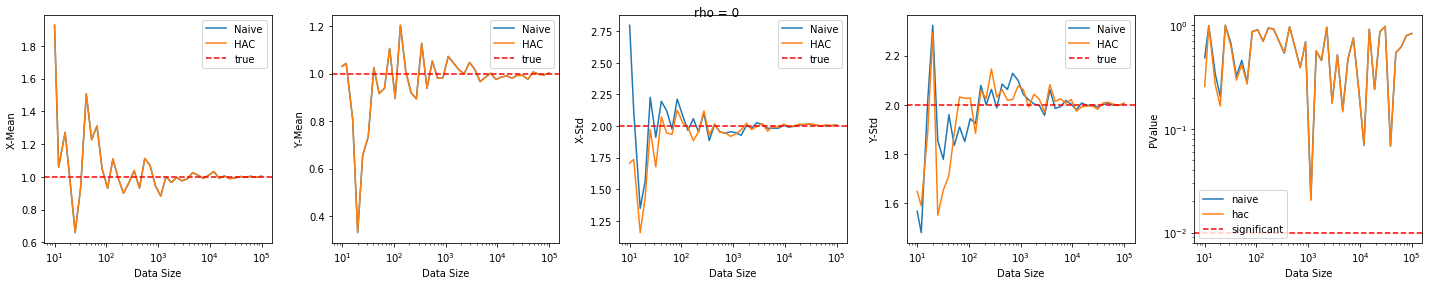

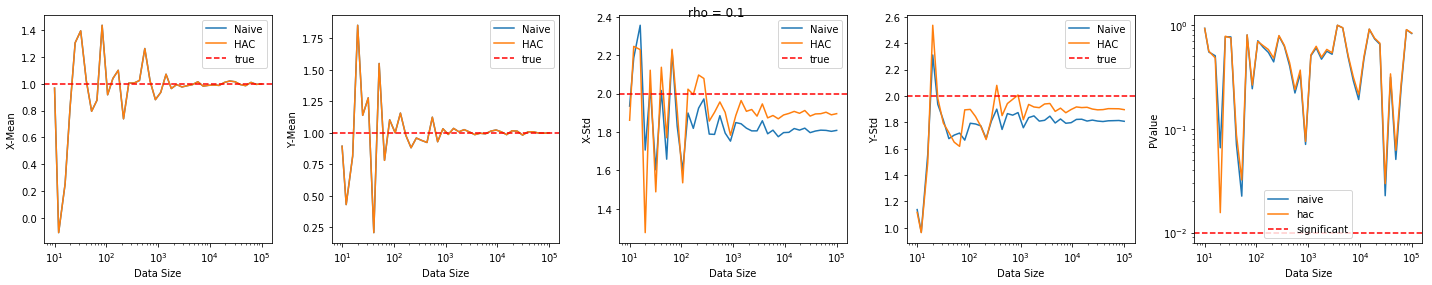

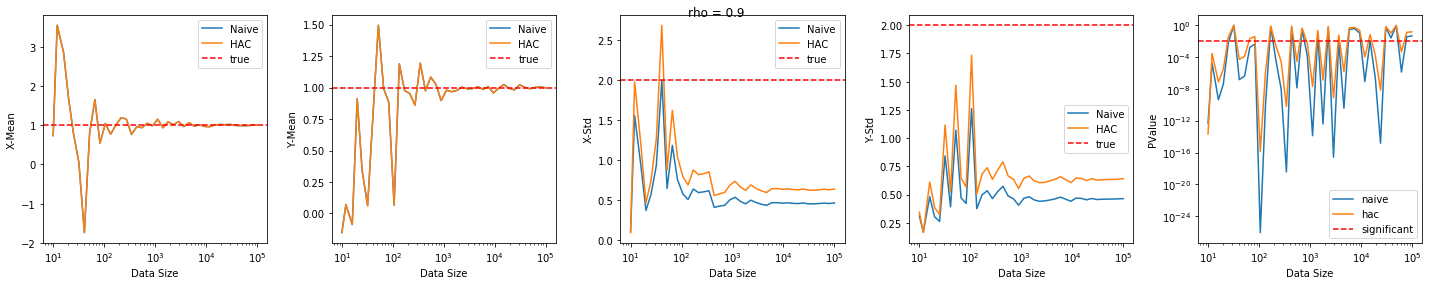

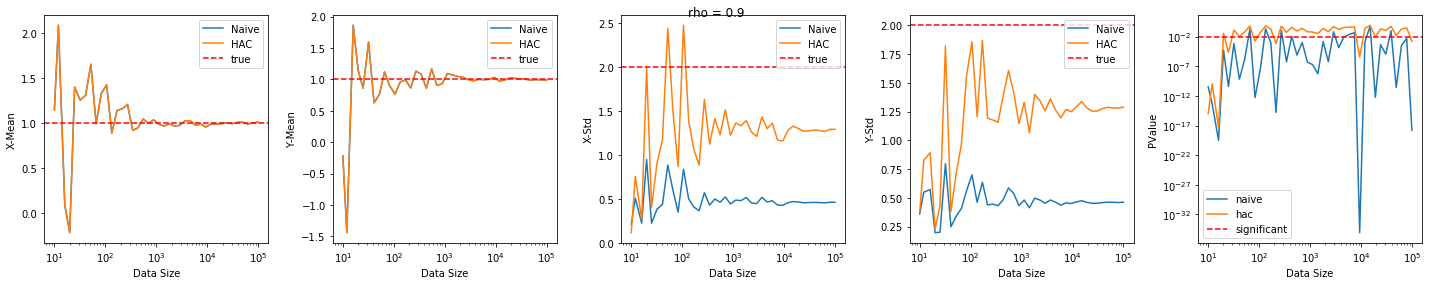

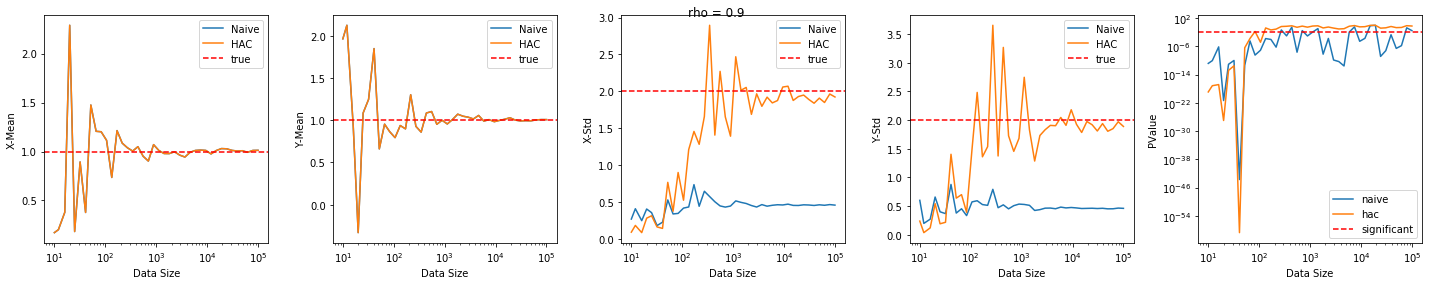

In [165]:
def ttest(x, y, hacLags=None):
    muX, stdX = get_mean_std(x, hacLags=hacLags)
    muY, stdY = get_mean_std(y, hacLags=hacLags)
    t, p = ttest_ind_from_stats(muX, stdX, len(x), muY, stdX, len(y))
    return t, p, muX, stdX, muY, stdY

def ttest_by_data_size(rho, hacLags):
    muTrue = 1
    stdTrue = 2
    
    rezNaive = []
    rezHAC = []
    nDataArr = (10**np.linspace(1, 5, 40)).astype(int)
    for nData in nDataArr:    
        x = np.random.normal(muTrue, stdTrue, nData)
        x = autocorr(x, rho)
        y = np.random.normal(muTrue, stdTrue, nData)
        y = autocorr(y, rho)
        rezNaive += [ttest(x, y)]
        rezHAC += [ttest(x, y, hacLags=hacLags)]
        
    rezNaive = np.array(rezNaive)
    rezHAC = np.array(rezHAC)

    fig, ax = plt.subplots(ncols=5, figsize=(20, 4), tight_layout=True)
    fig.suptitle("rho = "+str(rho))
    ax[0].semilogx(nDataArr, rezNaive[:, 2], label='Naive')
    ax[0].semilogx(nDataArr, rezHAC[:, 2],   label='HAC')
    ax[1].semilogx(nDataArr, rezNaive[:, 4], label='Naive')
    ax[1].semilogx(nDataArr, rezHAC[:, 4],   label='HAC')
    ax[2].semilogx(nDataArr, rezNaive[:, 3], label='Naive')
    ax[2].semilogx(nDataArr, rezHAC[:, 3],   label='HAC')
    ax[3].semilogx(nDataArr, rezNaive[:, 5], label='Naive')
    ax[3].semilogx(nDataArr, rezHAC[:, 5],   label='HAC')
    ax[4].loglog(nDataArr, rezNaive[:, 1], label='naive')
    ax[4].loglog(nDataArr, rezHAC[:, 1], label='hac')
    
    ax[0].axhline(y=muTrue, linestyle='--', color='r', label='true')
    ax[1].axhline(y=muTrue, linestyle='--', color='r', label='true')
    ax[2].axhline(y=stdTrue, linestyle='--', color='r', label='true')
    ax[3].axhline(y=stdTrue, linestyle='--', color='r', label='true')
    ax[4].axhline(y=0.01, linestyle='--', color='r', label='significant')
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    ax[4].legend()
    ax[0].set_xlabel('Data Size')
    ax[1].set_xlabel('Data Size')
    ax[2].set_xlabel('Data Size')
    ax[3].set_xlabel('Data Size')
    ax[4].set_xlabel('Data Size')
    ax[0].set_ylabel('X-Mean')
    ax[1].set_ylabel('Y-Mean')
    ax[2].set_ylabel('X-Std')
    ax[3].set_ylabel('Y-Std')
    ax[4].set_ylabel('PValue')
    plt.show()
    
ttest_by_data_size(0, 1)
ttest_by_data_size(0.1, 1)
ttest_by_data_size(0.9, 1)
ttest_by_data_size(0.9, 10)
ttest_by_data_size(0.9, 100)